# Using Sensitivity Analysis to Interrogate Models

Will Usher, UCL Energy Institute

10th December 2015

# Agenda

1. What is Sensitivity Analysis?
1. Sensitivity Analysis Techniques
1. Some (Interactive) Examples
1. Summary

In [1]:
import SALib
from ipywidgets import widgets, interact
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np


/Users/will2/miniconda3/envs/python3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
display(a)

NameError: name 'a' is not defined

#  Introduction

## Uncertainty and Modelling

We use models to encode natural phenomena

Examples of models:
* discounted cash flow analysis
* [Gina coefficient](https://en.wikipedia.org/wiki/Gini_coefficient#Based_on_just_two_levels_of_income) (statistical measure of inequality)
* UKTM - energy system model of the United Kingdom
* [MetUM](http://www.metoffice.gov.uk/research/modelling-systems/unified-model) - UK weather forecasting

## What is Sensitivity Analysis?

“...the study of how the uncertainty in the output of a mathematical model or system (numerical or otherwise) can be apportioned to different sources of uncertainty in its inputs.” 

The sensitivity of each input is often represented by a numeric value, called the sensitivity index. Sensitivity indices come in several forms:
* First-order indices: measures the contribution to the output variance by a single model input alone.
* Second-order indices: measures the contribution to the output variance caused by the interaction of two model inputs.
* Total-order index: measures the contribution to the output variance caused by a model input, including both its first-order effects (the input varying alone) and all higher-order interactions.

In [3]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

## [Lotka–Volterra equations](https://en.wikipedia.org/wiki/Lotka–Volterra_equations)

\begin{align}
\frac{dx}{dt} & = \alpha x - \beta x y \\[6pt]
\frac{dy}{dt} & = \delta x y  - \gamma y
\end{align}
where

* x is the number of prey (for example, rabbits);
* y is the number of some predator (for example, foxes);
* $\tfrac{dy}{dt}$ and $\tfrac{dx}{dt}$ represent the growth rates of the two populations over time;
* t represents time; and
* $\alpha$ is the natural growing rate of rabbits, when there's no fox
* $\beta$ is the natural dying rate of rabbits, due to predation
* $\gamma$ is the natural dying rate of fox, when there's no rabbit
* $\delta$ is the factor describing how many caught rabbits let create a new fox



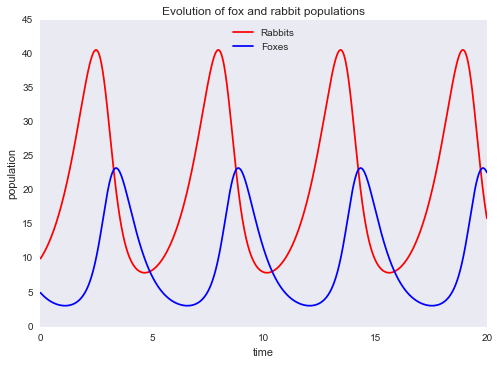

In [4]:
from scipy import integrate
from numpy import *
import pylab as p

@interact(a=widgets.FloatSlider(value=1., min=0.1, max=5, step=0.1), 
          b=widgets.FloatSlider(value=0.1, min=0.01, max=1.0, step=0.001), 
          c=widgets.FloatSlider(value=1.5, min=0.01, max=5.0, step=0.01), 
          d=widgets.FloatSlider(value=0.75, min=0.01, max=5.0, step=0.001))
def plot_lv_equations(a,b,c,d):

    def dX_dt(X, t=0):
        """ Return the growth rate of fox and rabbit populations. """
        return array([ a*X[0] -   b*X[0]*X[1] ,  
                      -c*X[1] + d*b*X[0]*X[1] ])

    t = linspace(0, 20,  1000)              # time
    X0 = array([10, 5])                     # initials conditions: 10 rabbits and 5 foxes  
    X = integrate.odeint(dX_dt, X0, t, full_output=False)
    rabbits, foxes = X.T
    f1 = p.figure()
    plt.plot(t, rabbits, 'r-', label='Rabbits')
    plt.plot(t, foxes  , 'b-', label='Foxes')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    plt.title('Evolution of fox and rabbit populations')

# Vehicle to Grid (V2G)

[Kempton (2005)](http://www.sciencedirect.com/science/article/pii/S0378775305000352) raise the prospect of using battery electric vehicles (BEVs) as mobile storage devices for electricity.  Other than pumped hydro, the electricity grid has virtually no storage devices.  Electricity storage could facilitate large capacities of variable output renewable technologies such as wind turbines and solar photovoltaics.

The concept of V2G is that electric the owners of electric (or even hydrogen fuel cell) vehicles could sacrifice some of their flexibility in return for hard cash by offering the use of their cars as giant batteries.


In [5]:
def max_vehicle_power(connector_power,
                      stored_energy,
                      distance_driven,
                      range_buffer,
                      dispatch_time,
                      driving_efficiency=4.025,
                      inverter_efficiency=0.93
                      ):
    '''
    Computed the maximum electrical power output of a vehicle in
    vehicle-to-grid
    
    Arguments:
        stored_energy - energy available as DC kWh to the invertor
        distance_driven - distance driven in km since energy storage full
        range_buffer - minimum range required by the driver in km
        driving_efficiency - 4.025 km/kWh
        inverter_efficiency - electrical conversion efficiency of DC to AC
                              inverter (93%)
        dispatch_time - time over which the vehicle's stored energy 
                        is dispatched in hours
    
    Returns:
        the minimum of the connector_power and maximum power for V2G in kW
    '''


    max_vehicle_power = ((stored_energy - \
                         ((distance_driven + range_buffer) \
                         / driving_efficiency)) * inverter_efficiency) \
                         / dispatch_time
    
    return np.maximum(0, np.minimum(connector_power, max_vehicle_power))

In [6]:
@interact(connector=widgets.FloatSlider(value=3.0, min=1.5, max=14, step=0.5), 
          battery_size=widgets.FloatSlider(value=30, min=10, max=100, step=10), 
          distance_driven=widgets.FloatSlider(value=0, min=0, max=100, step=5), 
          range_buffer=widgets.FloatSlider(value=0, min=0, max=100, step=10))
def plot_power(connector, battery_size, distance_driven, range_buffer):
    dispatch_time = 8
    return max_vehicle_power(connector,
                      battery_size,
                      distance_driven,
                      range_buffer,
                      dispatch_time
                      )

3.0

In [7]:
def monte_carlo(data):
    dispatch_time = 8
    y = max_vehicle_power(data[0], data[1], data[2], data[3], dispatch_time)
    return y

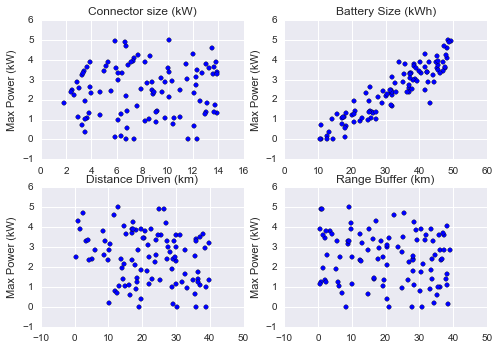

In [8]:
number_sims = 100

mc_connector = np.random.uniform(1.5, 14, number_sims)
mc_battery_size = np.random.uniform(10, 50, number_sims)
mc_distance_driven = np.random.uniform(0, 40, number_sims)
mc_range_buffer = np.random.uniform(0, 40, number_sims)
data = np.array((mc_connector, mc_battery_size, mc_distance_driven, mc_range_buffer))
y = monte_carlo(data)
plt.subplot(221)
plt.scatter(mc_connector, y)
plt.title("Connector size (kW)")
plt.ylabel("Max Power (kW)")
plt.subplot(222)
plt.scatter(mc_battery_size, y)
plt.title("Battery Size (kWh)")
plt.ylabel("Max Power (kW)")
plt.subplot(223)
plt.scatter(mc_distance_driven, y)
plt.title("Distance Driven (km)")
plt.ylabel("Max Power (kW)")
plt.subplot(224)
plt.scatter(mc_range_buffer, y)
plt.title("Range Buffer (km)")
plt.ylabel("Max Power (kW)")

In [9]:
from SALib.sample import morris as ms

In [10]:
problem = {
    'num_vars': 4,
    'names': ['conn', 'batt', 'dist', 'range'],
    'bounds': [[1.5, 14],
               [10, 50],
               [0, 40],
              [0, 40]],
    'groups': None
}

sample = ms.sample(problem, 100, num_levels=4, grid_jump=2, local_optimization=True)

In [11]:
output = monte_carlo(sample.T)
from SALib.analyze import morris
Si = morris.analyze(problem, sample, output)

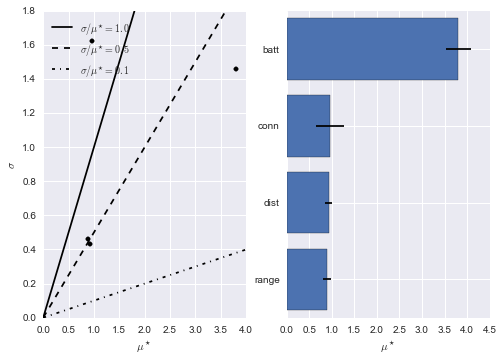

In [12]:
from SALib.plotting import morris as mp


fig, (ax1, ax2) = plt.subplots(1, 2)
p = mp.covariance_plot(ax1, Si, {})
p = mp.horizontal_bar_plot(ax2, Si)

In [ ]:
mp.covariance_plot?

In [ ]:
def battery_lifetime(lifetime_cycles,
                     total_energy_stored,
                     depth_of_discharge
                    ):
    '''
    Compute the lifetime of a battery in energy terms
    
    Arguments:
        lifetime_cycles - 
        total_energy_stored - size of battery (kWh)
        depth_of_discharge - the depth of discharge for which 
                            lifetime_cycles is defined (0 <= DoD <= 1)
    
    Returns:
        battery_lifetime in energy terms - units: kWh
    
    '''
    lifetime = lifetime_cycles * total_energy_stored * depth_of_discharge
    return lifetime

In [ ]:
rav4e = battery_lifetime(2000, 27.4, 0.8)

In [ ]:
rav4e

In [ ]:
def annualized_capital_cost(cost, discount_rate, lifetime):
    '''
    Arguments:
        cost - in GBP2015
        discount_rate - %
        lifetime - in years
    '''
    ann_cc = cost * (discount_rate / (1-(1+discount_rate)**-lifetime))
    return ann_cc

In [ ]:
annualized_capital_cost(1900, 0.1, 10)

In [ ]:
def compute_profit():

    time_dispatched = 8000 # hours

    battery_size = 27.4 # kWh
    battery_unit_cost = 350 # £/kWh

    connector_power = 14 # kW

    battery_capital_cost = battery_size * battery_unit_cost # 2015£
    lifetime_cycles = 2000
    depth_of_discharge = 0.8

    electricity_price = 0.2 # £/kWh - sell when its expensive
    purchased_energy_cost = 0.05 # £/kWh - buy when it's cheap

    round_trip_efficiency = 0.73 # 73% efficiency grid-battery-grid

    cost_of_v2g_equip = 2000
    discount_rate = 0.1 # 10%
    economic_lifetime = 10

    stored_energy = battery_size * depth_of_discharge # kWh
    distance_driven = 0 # km
    range_buffer = 10 # km

    power_available = max_vehicle_power(connector_power,
                                        stored_energy,
                                        distance_driven,
                                        range_buffer,
                                        8,
                                        )

    energy_dispatched = power_available * time_dispatched

    revenue = electricity_price * energy_dispatched

    cost = cost_of_vehicle_to_grid(battery_capital_cost,
                                   lifetime_cycles,
                                   battery_size,
                                   depth_of_discharge,
                                   purchased_energy_cost,
                                   round_trip_efficiency,
                                   energy_dispatched,
                                   cost_of_v2g_equip,
                                   discount_rate,
                                   economic_lifetime)

    if revenue > cost:
        profit = revenue - cost
    else:
        profit = 0

    return profit, revenue, cost

In [ ]:
compute_profit()

In [ ]:
def cost_of_vehicle_to_grid(battery_capital_cost,
                            lifetime_cycles,
                            total_energy_stored,
                            depth_of_discharge,
                            purchased_energy_cost,
                            round_trip_efficiency,
                            energy_dispatched,
                            cost_of_v2g_equip,
                            discount_rate,
                            economic_lifetime):
    
    battery_life = battery_lifetime(lifetime_cycles,
                                    total_energy_stored,
                                    depth_of_discharge
                                    )
    
    degredation_cost = battery_capital_cost / battery_life
    
    cost_of_energy = (purchased_energy_cost / round_trip_efficiency) \
                        + degredation_cost
    
    annualised_capex = annualized_capital_cost(cost_of_v2g_equip, 
                                               discount_rate, 
                                               economic_lifetime)
    
    cost = (cost_of_energy * energy_dispatched) + annualised_capex
    
    return cost